In [1]:
import galapy.internal.CPyISM as cism

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

Wavelenght grid:

In [4]:
ll = np.logspace( 0, 10, 300 )

Constants

In [5]:
Lsun = 3.828e+33

## Diffuse-Dust

In [6]:
dd = cism.CDD()

In [7]:
dd_dict = {
    'f_MC'  : 0.5,
    'norm'  : 1.,
    'Mdust' : 3.55988e+07,
    'Rdust' : 1000.,
    'f_PAH' : 0.2
}

In [8]:
np.asarray(dd_dict.values())

array(dict_values([0.5, 1.0, 35598800.0, 1000.0, 0.2]), dtype=object)

In [9]:
dd.set_params(np.asarray(list(dd_dict.values())))

In [10]:
dd.set_temperature( 37.53 )

In [11]:
dd.emission(1.e+6)

29481.75845724038

In [12]:
Ldd = dd.emission(ll)

In [13]:
Add   = dd.attenuation(ll)
Extdd = dd.extinction(ll) / dd.A_V()

## Molecular-Clouds

In [14]:
mc = cism.CMC()

In [15]:
mc_dict = {
    'f_MC'    : 0.5,
    'norm'    : 100.,
    'N_MC'    : 8.5e+03,
    'R_MC'    : 16,
    'Zgas'    : 0.466,
    'tau_esc' : 1.e+7,
    'Mgas'    : 8.51101e+09,
}

In [16]:
mc.set_params(np.asarray(list(mc_dict.values())))

In [17]:
mc.set_temperature( 30.74 )

In [18]:
mc.emission(1.e+6)

77835.11874051443

In [19]:
Lmc = mc.emission(ll)

In [20]:
Amc   = mc.attenuation(ll)
Extmc = mc.extinction(ll) / mc.A_V()

## Plots

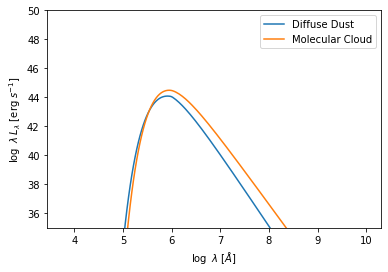

In [21]:
plt.ylim(35,50)
plt.xlabel( '$\\log\\ \\lambda\\ [\\AA]$' )
plt.ylabel( '$\\log\\ \\lambda\\; L_\\lambda\\ [$erg$\\; s^{-1}]$' )
plt.plot( np.ma.log10( ll ), np.ma.log10( ll * Lsun * Ldd ), label='Diffuse Dust' )
plt.plot( np.ma.log10( ll ), np.ma.log10( ll * Lsun * Lmc ), label='Molecular Cloud' )
_ = plt.legend()

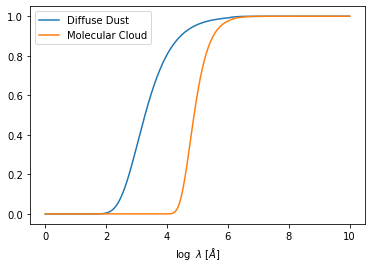

In [22]:
plt.xlabel( '$\\log\\ \\lambda\\ [\\AA]$' )
plt.plot( np.ma.log10( ll ), Add, label='Diffuse Dust' )
plt.plot( np.ma.log10( ll ), Amc, label='Molecular Cloud' )
_ = plt.legend()

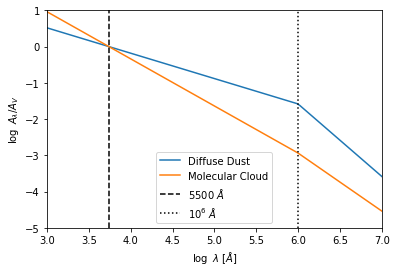

In [23]:
plt.xlim(3,7)
plt.ylim(-5,1)
plt.xlabel( '$\\log\\ \\lambda\\ [\\AA]$' )
plt.ylabel( '$\\log\\ A_\\lambda/A_V$' )
plt.plot( np.ma.log10( ll ), np.ma.log10( Extdd ), label='Diffuse Dust' )
plt.plot( np.ma.log10( ll ), np.ma.log10( Extmc ), label='Molecular Cloud' )
plt.axvline( np.log10(5500), c='k', ls='--', label='$5500\\ \\AA$' )
plt.axvline( 6, c='k', ls=':', label = '$10^6\\ \\AA$')
_ = plt.legend()

## Wrap-Up ISM

In [24]:
import galapy as gp
import galapy.internal.CPySFH as csfh
import galapy.internal.CPyCSP as ccsp

In [25]:
sfh = csfh.CSFH( 1.e+10 )

In [26]:
ll, tt, zz, LL = ccsp.loadSSP( gp.SSP_LIB['bc03.basel.chab.extend'] )

In [27]:
csp = ccsp.CCSP( ll, tt, zz, LL )
csp.set_params( *sfh.time_grid( 1.e+7, tt, zz ) )
#csp.emission( np.arange( len(ll), dtype = np.uint64 ) )

In [28]:
%%time
attDD = dd.attenuation(ll)
attMC = mc.attenuation(ll)
etaMC = mc.eta(tt)
attTot = np.ascontiguousarray( ( 1 - ( 1 - attMC )[:,np.newaxis] * etaMC[np.newaxis,:] ) * attDD[:,np.newaxis] )

CPU times: user 506 µs, sys: 4.55 ms, total: 5.06 ms
Wall time: 4.03 ms


In [29]:
%time attTotMC = ( 1 - ( 1 - attMC )[:,np.newaxis] * etaMC[np.newaxis,:] )

CPU times: user 2.62 ms, sys: 0 ns, total: 2.62 ms
Wall time: 1.93 ms


In [30]:
%time attTot = ( 1 - ( 1 - attMC )[:,np.newaxis] * etaMC[np.newaxis,:] ) * attDD[:,np.newaxis]

CPU times: user 3.36 ms, sys: 0 ns, total: 3.36 ms
Wall time: 2.63 ms


In [31]:
attTotMC.shape

(2223, 221)

In [32]:
# %time attTot = cism.total_attenuation( ll, attDD, attMC, etaMC )

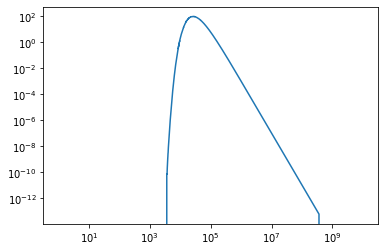

In [33]:
_ = plt.loglog( ll, csp.emission( np.arange( len(ll), dtype = np.uint64 ), attTot ) )

In [34]:
%%time
subidx = np.arange(0,len(ll),10,dtype=np.uint64)
lsub = ll[subidx]
sfh.set_params( np.asarray( [ 100, 3.e+8 ], dtype = float ) )
csp.set_params( *sfh.time_grid( 1.e+8, tt, zz ) )
dd.set_params(np.asarray(list(dd_dict.values())))
mc.set_params(np.asarray(list(mc_dict.values())))
attDD = dd.attenuation(lsub)
attMC = mc.attenuation(lsub)
etaMC = mc.eta(tt)
attTot = ( 1 - ( 1 - attMC )[:,np.newaxis] * etaMC[np.newaxis,:] ) * attDD[:,np.newaxis]
Latt = csp.emission( subidx, attTot )

CPU times: user 917 µs, sys: 841 µs, total: 1.76 ms
Wall time: 968 µs


In [35]:
Lunatt = csp.emission( subidx )

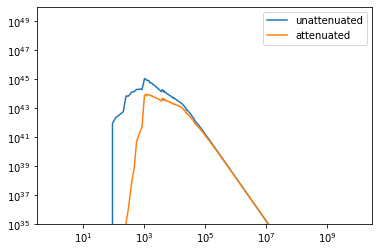

In [36]:
plt.ylim(1.e+35,1.e+50)
plt.loglog(lsub,lsub*Lsun*Lunatt,label='unattenuated')
plt.loglog(lsub,lsub*Lsun*Latt,  label='attenuated')
_ = plt.legend()

In [37]:
def trap_int ( xx, yy ) :
    xx = np.asarray(xx)
    yy = np.asarray(yy)
    b1b2 = yy[:-1] + yy[1:]
    hh = xx[1:] - xx[:-1]
    return np.sum( 0.5 * b1b2 * hh )

In [38]:
def perc ( x1, x2 ) :
    return abs( x1 - x2 ) / x2

Emission from ISM

In [39]:
%%time
subidx = np.arange(0,len(ll),1,dtype=np.uint64)
lsub = ll[subidx]
sfh.set_params( np.asarray( [ 100, 3.e+8 ], dtype = float ) )
csp.set_params( *sfh.time_grid( 1.e+8, tt, zz ) )
dd.set_params(np.asarray(list(dd_dict.values())))
mc.set_params(np.asarray(list(mc_dict.values())))
attDD = dd.attenuation(lsub)
attMC = mc.attenuation(lsub)
etaMC = mc.eta(tt)
attTotMC = 1 - ( 1 - attMC )[:,np.newaxis] * etaMC[np.newaxis,:]
attTot = attTotMC * attDD[:,np.newaxis]
Lunatt = csp.emission( subidx )
LattMC = csp.emission( subidx, attTotMC )
Latt = csp.emission( subidx, attTot )
Tdd = dd.temperature( 0.5 * Lsun * trap_int( lsub, ( LattMC - Latt ) ) )
Tmc = mc.temperature( 0.5 * Lsun * trap_int( lsub, ( Lunatt - LattMC ) ) )
Ldd = dd.emission(lsub)
Lmc = mc.emission(lsub)

CPU times: user 12.7 ms, sys: 544 µs, total: 13.3 ms
Wall time: 12.1 ms


In [40]:
Tdd, Tmc

(31.172640851526538, 32.12697836389634)

In [41]:
Lunatt = csp.emission( subidx )

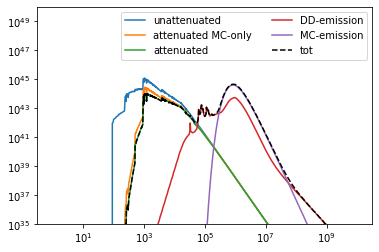

In [42]:
plt.ylim(1.e+35,1.e+50)
plt.loglog(lsub,lsub*Lsun*Lunatt,label='unattenuated')
plt.loglog(lsub,lsub*Lsun*LattMC,label='attenuated MC-only')
plt.loglog(lsub,lsub*Lsun*Latt,  label='attenuated')
plt.loglog(lsub,lsub*Lsun*Ldd,   label='DD-emission')
plt.loglog(lsub,lsub*Lsun*Lmc,   label='MC-emission')
plt.loglog(lsub,lsub*Lsun*(Latt+Ldd+Lmc), label='tot', color='k', ls='--')
_ = plt.legend(ncol=2)

In [43]:
idx = np.argwhere( ( 91 < lsub ) & ( lsub < 1.e+7 ) )
idx = idx[::100]

In [44]:
%time Eabs1 = trap_int( lsub[idx], ( Lunatt[idx] - Latt[idx] ) )
%time Eabs2 = trap_int( lsub, ( Lunatt - Latt ) )
perc( Eabs1, Eabs2 )

CPU times: user 87 µs, sys: 62 µs, total: 149 µs
Wall time: 77.2 µs
CPU times: user 206 µs, sys: 144 µs, total: 350 µs
Wall time: 216 µs


0.2402288967398466

In [45]:
%%time
Tdd1 = dd.temperature( 0.5 * Eabs1 * Lsun )
Tmc1 = mc.temperature( 0.5 * Eabs1 * Lsun )
print( Tdd1, Tmc1 )

44.33938154582157 31.28719471520037
CPU times: user 1.03 ms, sys: 0 ns, total: 1.03 ms
Wall time: 1.03 ms


In [46]:
%%time
Tdd2 = dd.temperature( 0.5 * Eabs2 * Lsun )
Tmc2 = mc.temperature( 0.5 * Eabs2 * Lsun )


CPU times: user 1.02 ms, sys: 0 ns, total: 1.02 ms
Wall time: 1.02 ms


In [47]:
print( perc( Tdd1, Tdd2 ), perc( Tmc1, Tmc2 ) )

0.0539359468274781 0.04998567328303403
